![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Compute Corrected Total water storage from GRACE

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geoslurp import GeoslurpManager
from geoslurp.tools.xarray import *

#local python tools
from common.config import read_config

In [3]:
shxengine='shtns' #requires shtns backend but is much quicker
nmax=96
conf=read_config()
datadir=conf['dataroot']


In [4]:
#load basin coefficients (truncated)
ncbasins=os.path.join(datadir,conf['ncbasin'])
dsbasins_sh=xr.open_dataset(ncbasins).sh.truncate(nmax=nmax)
dsbasins_sh=dsbasins_sh.sh.build_nmindex()
display(dsbasins_sh)

<xarray.Dataset> Size: 10MB
Dimensions:  (name: 124, nm: 9409)
Coordinates:
  * name     (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * nm       (nm) object 75kB MultiIndex
  * n        (nm) int64 75kB 0 1 1 1 2 2 2 2 2 3 ... 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 75kB 0 -1 0 1 -2 -1 0 1 2 ... 88 89 90 91 92 93 94 95 96
Data variables:
    basins   (name, nm) float64 9MB ...

In [5]:
#load static gravity field from database
gsman=GeoslurpManager(dbalias='marge',readonly_user=False)

In [6]:
icgemstatic=gsman.execute("select uri from shxarray.icgemstatic WHERE data->>'name' = 'GOCO06s' ").first()
staticfile=icgemstatic.uri.replace('${LOCALDATAROOT}',gsman.clientconf.dataroot)
dsstatic=xr.open_dataset(staticfile,engine='icgem').sh.truncate(nmax)



In [7]:
# get the degree 1 coefficients from TN13
qryd1="SELECT * FROM shxarray.deg1_tn13_csr_rl0602 ORDER BY time ASC"
#alternative (more noisy)
# qryd1="SELECT * FROM shxarray.geocenterriescfcm ORDER BY time ASC"
cols,dsdeg1=xr.Dataset.gslrp.load(gsman.conn,qryd1)
dsdeg1=dsdeg1.rename(id='time').assign_coords(time=[entry['time'] for entry in cols]).sh.build_nmindex()
display(dsdeg1)

<xarray.Dataset> Size: 13kB
Dimensions:  (time: 232, nm: 3)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-18 ... 2024-04-16
  * nm       (nm) object 24B MultiIndex
  * n        (nm) int64 24B 1 1 1
  * m        (nm) int64 24B 0 1 -1
Data variables:
    cnm      (time, nm) float64 6kB 5.12e-10 2.897e-10 ... -7.342e-11 2.295e-10
    sigcnm   (time, nm) float64 6kB 4.459e-11 4.53e-11 ... 4.53e-11 5.072e-11

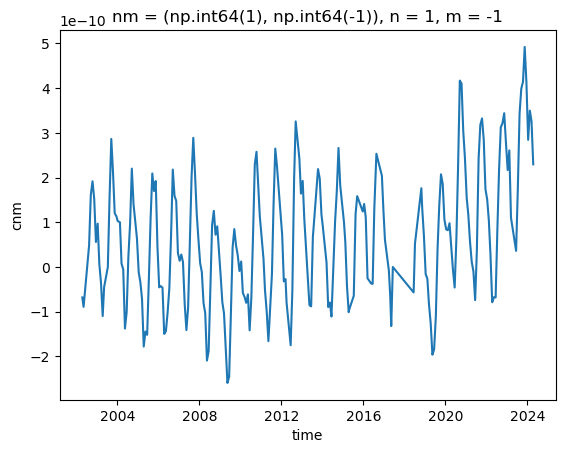

In [8]:
dsdeg1.cnm.sel(n=1,m=-1).plot()


In [9]:
#Get degree 2 SLR coefficients for TN14 doc
qryc20="SELECT * FROM shxarray.tn14slrgsfc WHERE nmax=2 ORDER BY time ASC"
cols,dsc20=xr.Dataset.gslrp.load(gsman.conn,qryc20)

dsc20=dsc20.rename(id='time').assign_coords(time=[entry['time'] for entry in cols]).sh.build_nmindex()

qryc23="SELECT * FROM shxarray.tn14slrgsfc WHERE nmax=3 ORDER BY time ASC"
cols,dsc23=xr.Dataset.gslrp.load(gsman.conn,qryc23)
dsc23=dsc23.rename(id='time').assign_coords(time=[entry['time'] for entry in cols]).sh.build_nmindex().sh.truncate(nmax=2,nmin=2)

dsc20=xr.concat([dsc20,dsc23],dim="time")

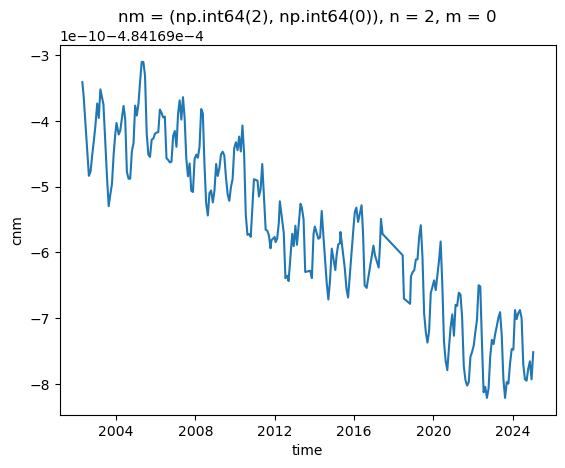

In [10]:
#visual check
dsc20.cnm.plot()

In [11]:
# get TUGRAZ GRACE solutions
qrygrc="SELECT * FROM shxarray.itsg_grace2018_monthly_n96 ORDER BY time ASC"
grclist=[entry.uri.replace('${LOCALDATAROOT}',gsman.clientconf.dataroot) for entry in gsman.execute(qrygrc)]

qrygrcfo="SELECT * FROM shxarray.itsg_grace_operational_monthly_n96 ORDER BY time ASC"
grclist.extend([entry.uri.replace('${LOCALDATAROOT}',gsman.clientconf.dataroot) for entry in gsman.execute(qrygrcfo)])

#Load all grace data
dsgrc=xr.open_mfdataset(grclist,engine="icgem")


In [12]:
#interpolate degree 1 on the GRACE/GFO timetags
dsdeg1_i=dsdeg1.interp(coords=dict(time=dsgrc.time),kwargs=dict(fill_value=np.nan))
#set degree 1 values to corrected values
dsgrc.cnm.loc[:,dsdeg1_i.nm]=dsdeg1_i.cnm
dsgrc.sigcnm.loc[:,dsdeg1_i.nm]=dsdeg1_i.sigcnm


In [13]:
#replace C20 (before subtracting a static field)
dsc20_i=dsc20.interp(coords=dict(time=dsgrc.time),kwargs=dict(fill_value=np.nan))
#set degree 1 values to corrected values
dsgrc.cnm.loc[:,dsc20_i.nm]=dsc20_i.cnm
dsgrc.sigcnm.loc[:,dsc20_i.nm]=dsc20_i.sigcnm

In [43]:
#subtract the static field
dsgrc['dcnm']=(dsgrc.cnm-dsstatic.cnm).compute()

In [83]:
# compute basin averages with leakage correction
dtws=dsgrc.dcnm[1:-8,:].sh.truncate(dsgrc.sh.nmax,1).compute().sh.tws()


dsbasinav=dtws.sh.basinav(dsbasins_sh.basins,filtername='Gauss300',leakage_corr='scale',engine=shxengine).compute()



shxarray-INFO: /home/roelof/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)


In [113]:
# also save tws SH coefficients
ncouttws=os.path.join(datadir,conf['nctws'])

dtws.reset_index(['nm']).to_netcdf(ncouttws)